# ISIC 2016 Challenge - Lesion Segmentation

Anna Putina,
Universitat Politècnica De Catalunya

The goal in this challenge is to create automated image analysis tools for early melanoma diagnosis, addressing a pressing public health issue with over 5,000,000 annual cases in the United States, and a global incidence of 350,000 cases in 2015, aiming to improve survival rates that can reach 95% with early detection.

The training dataset comprises 900 dermoscopic lesion images in JPEG format, accompanied by corresponding segmentation masks in PNG. The main task is to precisely outline skin lesions in the images, a crucial step in diagnosis.

The performance evaluation of the segmentation models involves a range of metrics computed at the pixel level. These metrics include sensitivity, specificity, accuracy, the Jaccard index, and the Dice coefficient.

For the purposes of this task, I use PyTorch, implementing a U-Net-like architecture to perform the lesion segmentation.

This notebook contains comments and explanations guiding each step of the work, with a detailed discussion of the results in the final "Results" section.

## Imports

Installing the necessary libraries

In [1]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=2c39452299c2d09110e0d6d3483d1bdd79bb54ab4437c1e6c71815ea29b41984
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=c3e48127a4e8acfe3dcd96b8462a0920206460b565bbf6fc51c22e5a045e99d7
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

In [2]:
!pip install torchinfo

In [3]:
#Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Image manipulation
from PIL import Image

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.auto import tqdm

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss

Since the primary task is the implementation of U-Net from scratch, secondary functions such as training, calculating metrics, and plotting have been moved to separate files to avoid cluttering the code. To use them, you need to upload them to Colab (they are located in a .zip archive along with this notebook).

In [42]:
# From local helper files
from helper_evaluation import compute_accuracy_loss
from helper_metrics import check_metrics
from helper_train import train_model
from helper_plotting import plot_loss_accuracy,  plot_img_mask_pred

Variables and parameters

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate =5e-4
batch_size = 16
epochs = 50
size =(128,128)

In [6]:
device

device(type='cuda')

## Data loading

To upload the data, you first need to upload both folders (one with images and another with masks) to your Google Drive, and then mount your Google Drive to Colab.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Define the base directory where images and ground truth data are stored
base_dir = '/content/drive/My Drive/'

# Define the subdirectories for images and ground truth
image_folder = "ISBI2016_ISIC_Part1_Training_Data"
gt_folder = "ISBI2016_ISIC_Part1_Training_GroundTruth"

# Combine the base directory with subdirectories
image_dir = os.path.join(base_dir, image_folder)
gt_dir = os.path.join(base_dir, gt_folder)

# Get paths to the training and target images
image_paths = sorted([os.path.join(image_dir, fname)
                      for fname in os.listdir(image_dir)
                      if fname.endswith(".jpg")])
gt_paths = sorted([os.path.join(gt_dir, fname)
                    for fname in os.listdir(gt_dir)
                    if fname.endswith(".png")])

# Check if dimensions are equal
print("Number of samples in the image folder:", len(image_paths))
print("Number of samples in the mask folder:", len(gt_paths))

Number of samples in the image folder: 900
Number of samples in the mask folder: 900


Visualisation of an image with its corresponding mask

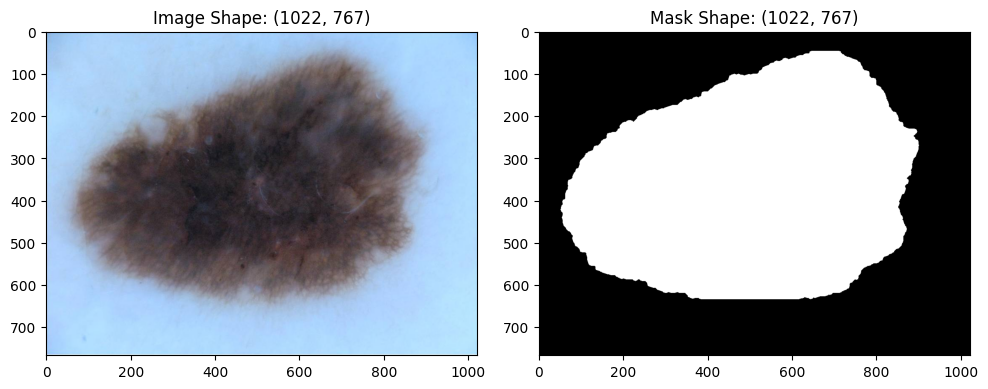

In [9]:
# Define the paths to your image and segmentation mask
image_path = image_paths[0]
mask_path = gt_paths[0]

# Open the image and mask using Pillow
image = Image.open(image_path)
mask = Image.open(mask_path)

# Get the dimensions (shape) of the image and mask
image_shape = image.size  # Returns (width, height)
mask_shape = mask.size    # Returns (width, height)

# Convert the image and mask to NumPy arrays for visualization
image_array = plt.imread(image_path)
mask_array = plt.imread(mask_path)

# Plot the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title(f"Image Shape: {image_shape}")

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_array, cmap='gray')  # Assuming the mask is grayscale
plt.title(f"Mask Shape: {mask_shape}")

# Show the plots
plt.tight_layout()
plt.show()

## Creating datasets and dataloaders

Initially, we divide our dataset into training, validation, and test sets. I tried different proportions, and when evaluating the model's performance, I settled on the following ratios.

In [10]:
percentage_test = 0.05
percentage_validation = 0.1

# Set your random seed for reproducibility
random_seed = 142

# Split your data into training, validation, and test sets
image_paths_trainval, image_paths_test, mask_paths_trainval, mask_paths_test = train_test_split(image_paths, gt_paths, test_size=percentage_test, random_state=random_seed)
image_paths_train, image_paths_val, mask_paths_train, mask_paths_val = train_test_split(image_paths_trainval, mask_paths_trainval, test_size=percentage_validation, random_state=random_seed)


Dataset Class

In [11]:
class LesionSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        mask_name = self.mask_paths[idx]

        img = Image.open(img_name)
        mask = Image.open(mask_name)

        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0

        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
        return img,mask

 Image data augmentation was performed using the Albumentations library as part of the preprocessing pipeline. Two sets of augmentation operations were defined: `train_transform` for training images and `val_transform` for validation images. The `train_transform` included resizing, random rotations, horizontal flips, and pixel value normalization, with the aim of enhancing the diversity of the training data and improving the model's generalization ability. On the other hand, the `val_transform` focused primarily on resizing and normalization to ensure consistency in the validation set.

In [12]:
train_transform = A.Compose([A.Resize(size[0],size[1]),
                             A.Rotate(limit=15,p=0.1),
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(size[0],size[1]),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

Datasets

In [13]:
train_dataset =  LesionSegmentationDataset(image_paths_train, mask_paths_train, transform = train_transform)
val_dataset = LesionSegmentationDataset(image_paths_val, mask_paths_val, transform = val_transform)
test_dataset = LesionSegmentationDataset(image_paths_test, mask_paths_test, transform = val_transform)

Dataloaders

In [14]:
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

## Plotting Images and Masks from Datasets

In the plotting function `plot_img_mask_pred`, a random sample is chosen to be plotted.

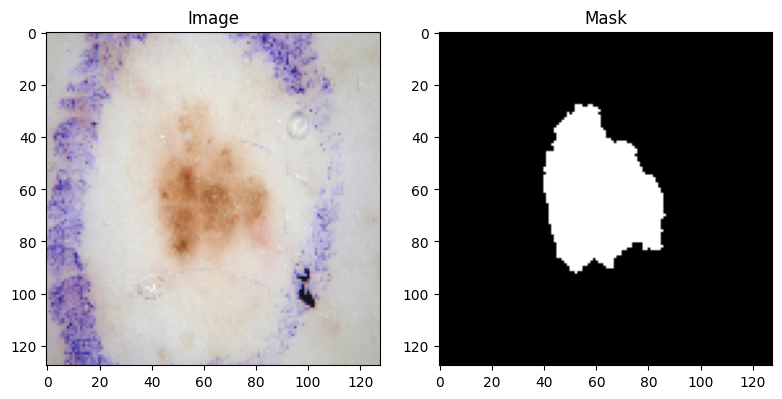

In [61]:
plot_img_mask_pred(train_dataset)

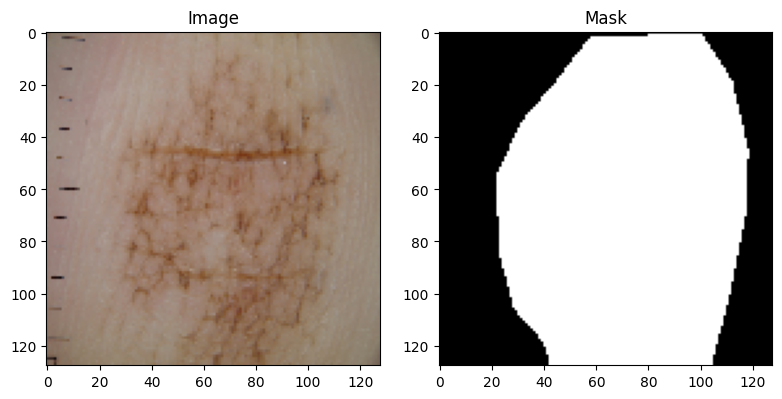

In [62]:
plot_img_mask_pred(val_dataset)

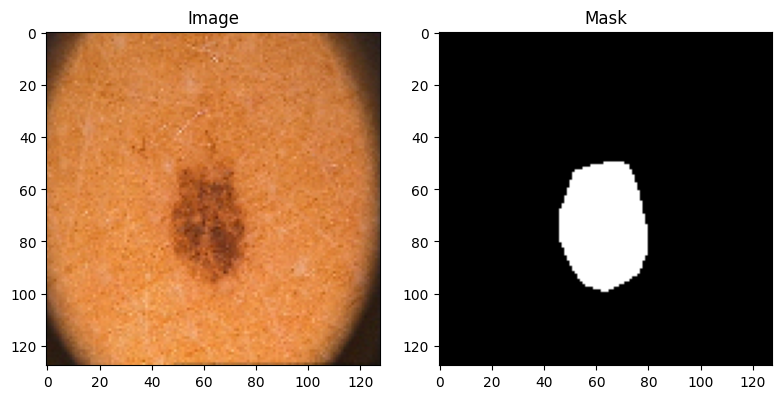

In [63]:
plot_img_mask_pred(test_dataset)

## Model Definition

U-Net is a convolutional neural network (CNN) architecture used extensively for image segmentation tasks. It is characterized by a U-shaped structure consisting of an encoder, a bottleneck, and a decoder.

In [15]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3,stride=1,padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x)))).to(device)


In [16]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [17]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs  = chs
        self.upconvs  = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x  = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [18]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder  = Decoder(dec_chs)
        self.head  = nn.Conv2d(dec_chs[-1], num_class, 1)


    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        return out

Unlike the standard U-Net architecture described in the original paper, I used `padding=1` for the convolutional layers to maintain the dimension of the output. This is because the mask and the mole image must have the same size.

I also couldn't use larger channel dimensions (e.g., 512 and 1024) because it significantly increases the number of model parameters and, consequently, the memory requirements. However, I added a layer with 32 channels, which helped capture important information from the images, and the model's performance improved compared to the version without this layer.

## Training

I tried different combinations of loss functions (Jaccard, Soft BCE, and BCE) and optimizers (SGD, Adam, and RMSprop). In the end, I settled on using Adam as the optimizer and Binary Cross-Entropy as the loss function.

I also implement a decreasing learning rate to avoid oscillatory behavior of the loss function near the minimum. This helped the model converge more effectively and reach a better solution.

In [64]:
model = UNet(enc_chs=(3,32, 64,128,256), dec_chs=(256, 128, 64, 32), num_class=1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=learning_rate/epochs)
#optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()
#criterion = SoftBCEWithLogitsLoss()
#criterion = JaccardLoss()

scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min', verbose=True)

In [20]:
model.to(device)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [21]:
summary(model, input_size=(batch_size,3, size[0],size[1]))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 1, 128, 128]         --
├─Encoder: 1-1                           [16, 32, 128, 128]        --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-1                   [16, 32, 128, 128]        10,144
│    └─MaxPool2d: 2-2                    [16, 32, 64, 64]          --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-2                   [16, 64, 64, 64]          55,424
│    └─MaxPool2d: 2-4                    [16, 64, 32, 32]          --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-3                   [16, 128, 32, 32]         221,440
│    └─MaxPool2d: 2-6                    [16, 128, 16, 16]         --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-4              

In [22]:
train_loss_lst, valid_loss_lst, valid_acc_lst = train_model(model, epochs, train_dataloader, val_dataloader,
                                criterion, optimizer,device, scheduler=scheduler, scheduler_on='train_loss')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 01/50 | Train Loss: 0.5485 | Validation Loss: 0.5060 | Validation Accuracy: 70.7%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 02/50 | Train Loss: 0.4440 | Validation Loss: 0.5350 | Validation Accuracy: 77.3%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 03/50 | Train Loss: 0.3924 | Validation Loss: 0.4617 | Validation Accuracy: 80.0%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 04/50 | Train Loss: 0.3427 | Validation Loss: 0.4147 | Validation Accuracy: 82.0%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 05/50 | Train Loss: 0.3285 | Validation Loss: 0.3240 | Validation Accuracy: 86.6%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 06/50 | Train Loss: 0.3110 | Validation Loss: 0.4078 | Validation Accuracy: 82.3%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 07/50 | Train Loss: 0.3050 | Validation Loss: 0.3098 | Validation Accuracy: 87.2%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 08/50 | Train Loss: 0.2900 | Validation Loss: 0.3809 | Validation Accuracy: 84.5%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 09/50 | Train Loss: 0.2944 | Validation Loss: 0.3522 | Validation Accuracy: 85.0%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 10/50 | Train Loss: 0.2660 | Validation Loss: 0.2671 | Validation Accuracy: 89.3%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 11/50 | Train Loss: 0.2399 | Validation Loss: 0.2492 | Validation Accuracy: 89.9%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 12/50 | Train Loss: 0.2056 | Validation Loss: 0.2209 | Validation Accuracy: 91.0%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 13/50 | Train Loss: 0.1900 | Validation Loss: 0.2021 | Validation Accuracy: 91.4%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 14/50 | Train Loss: 0.1935 | Validation Loss: 0.2472 | Validation Accuracy: 90.1%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 15/50 | Train Loss: 0.1927 | Validation Loss: 0.2087 | Validation Accuracy: 92.4%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 16/50 | Train Loss: 0.1814 | Validation Loss: 0.2178 | Validation Accuracy: 90.7%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 17/50 | Train Loss: 0.1694 | Validation Loss: 0.1837 | Validation Accuracy: 91.8%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 18/50 | Train Loss: 0.1574 | Validation Loss: 0.1749 | Validation Accuracy: 92.3%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 19/50 | Train Loss: 0.1943 | Validation Loss: 0.1880 | Validation Accuracy: 93.2%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 20/50 | Train Loss: 0.1601 | Validation Loss: 0.1648 | Validation Accuracy: 93.0%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 21/50 | Train Loss: 0.1502 | Validation Loss: 0.1532 | Validation Accuracy: 93.3%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 22/50 | Train Loss: 0.1466 | Validation Loss: 0.1687 | Validation Accuracy: 92.2%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 23/50 | Train Loss: 0.1449 | Validation Loss: 0.1522 | Validation Accuracy: 93.2%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 24/50 | Train Loss: 0.1421 | Validation Loss: 0.1456 | Validation Accuracy: 93.6%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 25/50 | Train Loss: 0.1392 | Validation Loss: 0.1641 | Validation Accuracy: 92.3%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 26/50 | Train Loss: 0.1476 | Validation Loss: 0.1519 | Validation Accuracy: 92.6%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 27/50 | Train Loss: 0.1413 | Validation Loss: 0.1619 | Validation Accuracy: 92.3%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 28/50 | Train Loss: 0.1346 | Validation Loss: 0.1416 | Validation Accuracy: 93.7%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 29/50 | Train Loss: 0.1324 | Validation Loss: 0.1412 | Validation Accuracy: 94.0%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 30/50 | Train Loss: 0.1332 | Validation Loss: 0.1393 | Validation Accuracy: 93.7%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 31/50 | Train Loss: 0.1281 | Validation Loss: 0.1412 | Validation Accuracy: 93.6%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 32/50 | Train Loss: 0.1308 | Validation Loss: 0.1624 | Validation Accuracy: 93.6%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 33/50 | Train Loss: 0.1390 | Validation Loss: 0.1440 | Validation Accuracy: 93.3%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 34/50 | Train Loss: 0.1286 | Validation Loss: 0.1427 | Validation Accuracy: 93.8%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 35/50 | Train Loss: 0.1293 | Validation Loss: 0.1444 | Validation Accuracy: 93.8%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 36/50 | Train Loss: 0.1184 | Validation Loss: 0.1483 | Validation Accuracy: 94.3%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 37/50 | Train Loss: 0.1222 | Validation Loss: 0.1346 | Validation Accuracy: 94.3%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 38/50 | Train Loss: 0.1199 | Validation Loss: 0.1381 | Validation Accuracy: 93.6%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 39/50 | Train Loss: 0.1205 | Validation Loss: 0.1415 | Validation Accuracy: 93.7%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 40/50 | Train Loss: 0.1191 | Validation Loss: 0.1387 | Validation Accuracy: 94.0%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 41/50 | Train Loss: 0.1266 | Validation Loss: 0.1314 | Validation Accuracy: 94.2%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 42/50 | Train Loss: 0.1196 | Validation Loss: 0.1420 | Validation Accuracy: 93.7%
Epoch 00042: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 43/50 | Train Loss: 0.1094 | Validation Loss: 0.1257 | Validation Accuracy: 94.5%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 44/50 | Train Loss: 0.1047 | Validation Loss: 0.1271 | Validation Accuracy: 94.4%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 45/50 | Train Loss: 0.1043 | Validation Loss: 0.1272 | Validation Accuracy: 94.4%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 46/50 | Train Loss: 0.1040 | Validation Loss: 0.1274 | Validation Accuracy: 94.4%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 47/50 | Train Loss: 0.1022 | Validation Loss: 0.1277 | Validation Accuracy: 94.4%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 48/50 | Train Loss: 0.1019 | Validation Loss: 0.1279 | Validation Accuracy: 94.4%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 49/50 | Train Loss: 0.1028 | Validation Loss: 0.1275 | Validation Accuracy: 94.4%


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 50/50 | Train Loss: 0.1021 | Validation Loss: 0.1290 | Validation Accuracy: 94.3%


The plots I received for Loss and Accuracy

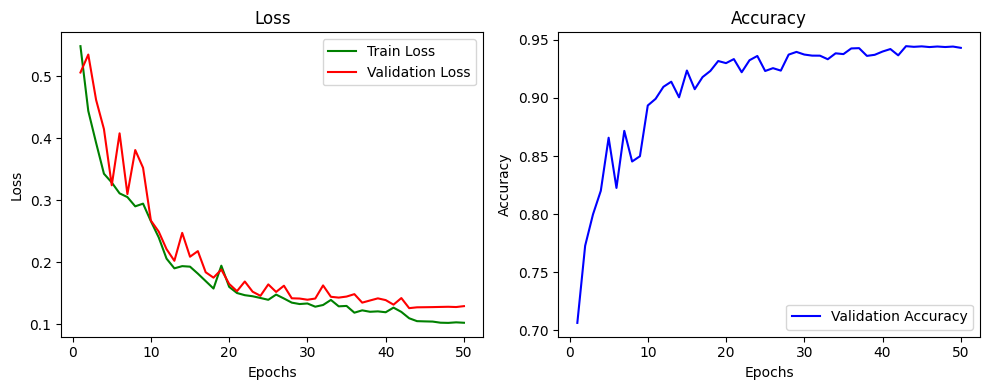

In [43]:
plot_loss_accuracy(train_loss_lst, valid_loss_lst, valid_acc_lst)

In [44]:
model.eval()

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

## Saving part

This piece of code was necessary for me as I was saving different models while trying different parameters to be able to compare their performances.

In [29]:
# Save the model to your Google Drive
torch.save(model.state_dict(), '/content/drive/My Drive/segmentation_model.pth')

In [66]:
# Initialize an empty model with the same architecture
upload_model = UNet(enc_chs=(3,32, 64,128,256), dec_chs=(256, 128, 64, 32), num_class=1)

In [67]:
# Load the model from Google Drive
model_path = '/content/drive/My Drive/model.pth'
upload_model.load_state_dict(torch.load(model_path,  map_location=torch.device('cpu')))
#upload_model.eval()
#upload_model.to(device)

<All keys matched successfully>

## Metrics

The metrics that are used to analyze the performance of the model for this task are fundamental for image segmentation models.

1. **Sensitivity (True Positive Rate, Recall):**
   - Sensitivity measures the ability of a segmentation model to correctly identify positive instances.
   - Formula: Sensitivity = (True Positives) / (True Positives + False Negatives)

2. **Specificity:**
   - Specificity measures the ability of a segmentation model to correctly identify negative instances.
   - Formula: Specificity = (True Negatives) / (True Negatives + False Positives)

3. **Pixel Accuracy:**
   - Pixel accuracy assesses the overall correctness of pixel-wise predictions.
   - Formula: Pixel Accuracy = (Correctly Classified Pixels) / (Total Pixels)

4. **Jaccard Score (Intersection over Union, IoU):**
   - The Jaccard Score calculates the intersection over the union of the predicted and ground truth segmentation masks.
   - Formula: IoU = (Intersection) / (Union)

5. **Dice Score (F1 Score):**
   - The Dice Score measures the similarity between the predicted and ground truth masks.
   - Formula: Dice Score = (2 * True Positives) / (2 * True Positives + False Positives + False Negatives)



In [47]:
sensetivity, specificity, accuracy, jaccard, dice = check_metrics(test_dataloader, model, device="cuda")

Sensitivity: 0.871129
Specificity: 0.969473
Pixel Accuracy: 0.957221
Jaccard Score: 0.805167
Dice Score: 0.884766


## Plotting the result

The graphs below demonstrate the performance of the model for one of the test samples. They provide a visual comparison between the predicted mask and the ground truth one.

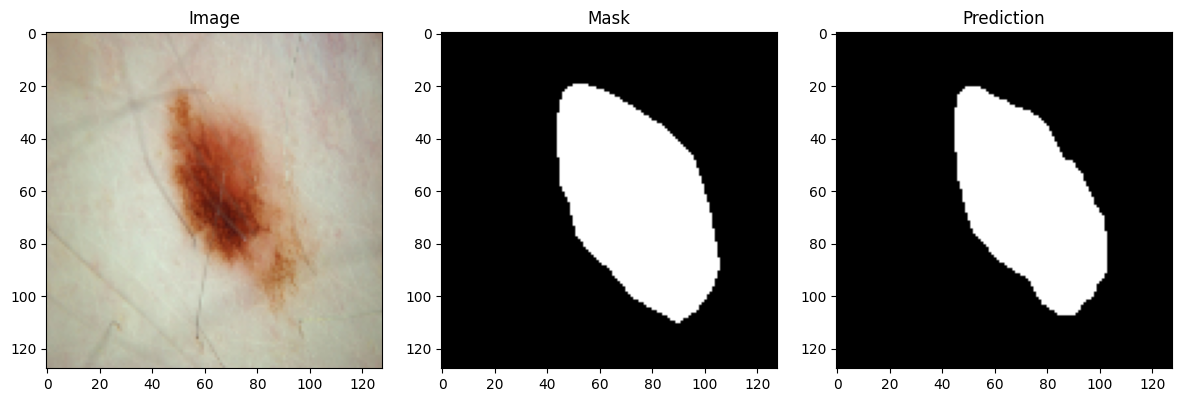

In [60]:
plot_img_mask_pred(test_dataset, plot_pred=True, model=model, device = "cuda")

## Results

The parameters I adjusted during the model training process are as follows:

1. Image size: I settled on a size of 128x128, as it had a minimal negative  impact on performance while significantly reducing memory usage.

2. Number of channels in the convolutional layers of the U-Net.

3. Learning rate, which I chose to decrease based on the loss function's behavior.

4. Batch  size: I opted for a relatively large batch size of 16 to expedite training without consuming excessive memory.

5. Loss function: I found that there was no noticeable difference between Soft BCE and BCE loss, and the model trained poorly with Jaccard.

6. Optimizer: I selected Adam as it was the fastest optimizer for this specific task.

7. Number of epochs: I tried to use as many epochs as possible (50), observing when the loss function almost stopped changing, indicating that the model had learned as much as possible.

8. Data augmentation: I applied standard image transformations for segmentation tasks, using a convenient library that could transform both the mask and the image simultaneously.

The final parameters can be found in the code within this notebook.